# Can hit vs miss trials be predicted by prestimulus neural activity?

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#generic imports
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.extend(['..','../..'])
import pandas as pd
import seaborn as sns

In [3]:
# stats
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scipy import interp

In [4]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [5]:
def plot_roc_curve_multi(fpr_list, tpr_list):
    fig, ax = plt.subplots(1,1)
    for i in range(len(fpr_list)):
        ax.plot(fpr_list[i], tpr_list[i], color='orange',label=i,alpha=0.7)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.show()

In [6]:
def find(lst, condition):
    return [i for i, x in enumerate(lst) if x == condition]

def index(lst, indices):
    return [x for i, x in enumerate(lst) if i in indices]

def smaller(lst, value):
    return [i for i, x in enumerate(lst) if x < value]

def larger(lst, value):
    return [i for i, x in enumerate(lst) if x > value]

def absolute(lst, value):
    return [i for i, x in enumerate(lst) if abs(x) > value]

In [15]:
data = np.load('/home/jrowland/Documents/code/d2p/data/session1.npy')
data.shape

(1695, 93, 10)

In [24]:
trial_info = np.load('/home/jrowland/Documents/code/d2p/data/trial_info.npy', allow_pickle=True)
trial_info = trial_info[()]

In [25]:
trial_info.keys()

dict_keys(['trial_type', 'outcome', 'trial_stim'])

In [26]:
trial_type = trial_info['trial_type']
trial_type

array(['go', 'nogo', 'go', 'go', 'nogo', 'nogo', 'nogo', 'go', 'nogo',
       'nogo', 'go', 'nogo', 'nogo', 'go', 'nogo', 'go', 'go', 'nogo',
       'nogo', 'go', 'go', 'go', 'nogo', 'nogo', 'nogo', 'nogo', 'nogo',
       'nogo', 'go', 'nogo', 'go', 'go', 'nogo', 'nogo', 'nogo', 'nogo',
       'nogo', 'go', 'nogo', 'nogo', 'go', 'go', 'go', 'nogo', 'go', 'go',
       'go', 'go', 'go', 'nogo', 'go', 'nogo', 'nogo', 'nogo', 'go', 'go',
       'go', 'go', 'nogo', 'nogo', 'nogo', 'go', 'nogo', 'nogo', 'nogo',
       'nogo', 'go', 'nogo', 'nogo', 'go', 'nogo', 'go', 'go', 'nogo',
       'nogo', 'go', 'nogo', 'go', 'nogo', 'go', 'go', 'nogo', 'nogo',
       'go', 'go', 'go', 'nogo', 'go', 'nogo', 'go', 'go', 'nogo', 'nogo'],
      dtype='<U4')

In [27]:
outcome =trial_info['outcome']
outcome

array(['hit', 'fp', 'hit', 'hit', 'fp', 'fp', 'cr', 'hit', 'fp', 'fp',
       'miss', 'cr', 'cr', 'miss', 'fp', 'miss', 'hit', 'cr', 'fp',
       'miss', 'miss', 'hit', 'fp', 'cr', 'cr', 'fp', 'fp', 'fp', 'hit',
       'cr', 'hit', 'hit', 'fp', 'fp', 'cr', 'cr', 'cr', 'hit', 'fp',
       'cr', 'miss', 'miss', 'miss', 'cr', 'miss', 'hit', 'miss', 'hit',
       'hit', 'cr', 'hit', 'cr', 'fp', 'cr', 'hit', 'hit', 'hit', 'hit',
       'fp', 'fp', 'fp', 'hit', 'fp', 'cr', 'cr', 'fp', 'hit', 'fp', 'cr',
       'hit', 'fp', 'hit', 'hit', 'cr', 'cr', 'hit', 'fp', 'hit', 'cr',
       'miss', 'hit', 'cr', 'fp', 'miss', 'miss', 'miss', 'cr', 'miss',
       'fp', 'miss', 'miss', 'cr', 'cr'], dtype='<U4')

In [28]:
# find the indices of all go trials
go_indices = find(trial_type,condition='go')

In [29]:
# find the labels of all go trials; should all be hit or miss
go_labels = index(outcome,go_indices)
len(go_labels)

43

In [30]:
# binarise go labels
labels = np.zeros((len(go_labels)))
hitti = find(go_labels,'hit')
for i in hitti:
    labels[i] = 1

In [31]:
labels

array([1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0.])

In [32]:
go_labels

['hit',
 'hit',
 'hit',
 'hit',
 'miss',
 'miss',
 'miss',
 'hit',
 'miss',
 'miss',
 'hit',
 'hit',
 'hit',
 'hit',
 'hit',
 'miss',
 'miss',
 'miss',
 'miss',
 'hit',
 'miss',
 'hit',
 'hit',
 'hit',
 'hit',
 'hit',
 'hit',
 'hit',
 'hit',
 'hit',
 'hit',
 'hit',
 'hit',
 'hit',
 'hit',
 'miss',
 'hit',
 'miss',
 'miss',
 'miss',
 'miss',
 'miss',
 'miss']

In [33]:
#shufffle labels for a sanity check later
labels_binary_shuffled = np.random.permutation(labels)

In [34]:
#take just the go trials
go_trials = data[:,go_indices,:]
go_trials.shape

(1695, 43, 10)

In [35]:
go_trials[0][0]

array([-0.30152196, -0.33446676, -0.40903464, -0.48798752, -0.46266845,
       -0.5462786 , -0.41115439, -0.405965  , -0.35862443, -0.47198457])

In [36]:
#split trials in to pre and post stimulus (stim is after 5th frame)
trials_pre, trials_post = np.split(go_trials,2,axis=2) 
trials_pre.shape

(1695, 43, 5)

In [37]:
#select different frames here for sanity checking
# trials_pre = go_trials[:,:,5:10]

In [38]:
#check this is the first n frames of go_trials[0][0]
trials_pre[0][0]

array([-0.30152196, -0.33446676, -0.40903464, -0.48798752, -0.46266845])

# ROC with decision variable as population mean

In [39]:
# calculate mean pre stimulus response for each trial, for each cell
mean_dff_cell = np.mean(trials_pre,axis=2)

# calculate mean response over the population for each trial
mean_dff_trial = np.mean(mean_dff_cell, axis = 0)

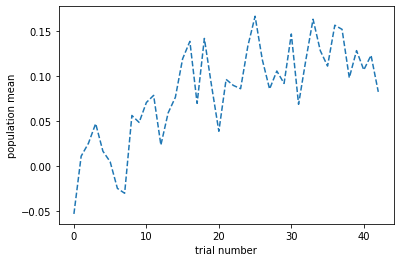

In [40]:
plt.plot(mean_dff_trial,'--')
plt.xlabel('trial number')
plt.ylabel('population mean')
plt.show()

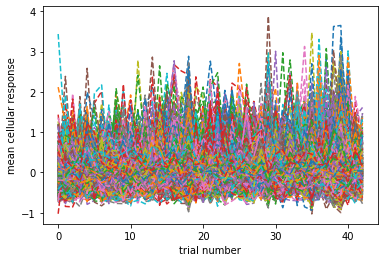

In [41]:
plt.plot(mean_dff_cell.T,'--')
plt.xlabel('trial number')
plt.ylabel('mean cellular response')
plt.show()

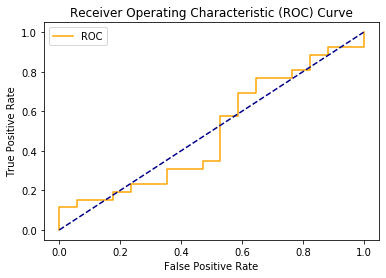

AUC: 0.49


In [42]:
# make ROC curve 
fpr, tpr, thresholds = roc_curve(labels, mean_dff_trial)
plot_roc_curve(fpr, tpr)
aucc = roc_auc_score(labels, mean_dff_trial)
print('AUC: %.2f' % aucc)

## logistic regression classifier

### 1. scale data such that it has zero-mean with unit variance

In [43]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(mean_dff_cell)
mean_dff_cell_scaled = scaler.transform(mean_dff_cell)

# 2. Train model with 10-fold cross-validation
https://scikit-learn.org/stable/modules/cross_validation.html

In [44]:
clf = linear_model.LogisticRegression(max_iter=1e8, tol=1e-4,penalty='l2',solver='lbfgs')
scores = cross_val_score(clf, mean_dff_cell_scaled.T, labels, cv=10)

In [45]:
scores

array([0.6       , 0.4       , 0.6       , 0.6       , 0.6       ,
       0.8       , 1.        , 1.        , 1.        , 0.66666667])

In [46]:
print("Model accuracy: %0.2f (95%% CI +/- %0.2f)" % (scores.mean(), scores.std() * 1.96))

Model accuracy: 0.73 (95% CI +/- 0.39)


# 3. cross validated ROC to evaluate performance on predicting test data

In [47]:
X = mean_dff_cell_scaled.T
y = labels
folds = 5

cv = StratifiedKFold(n_splits=folds)
classifier = linear_model.LogisticRegression(max_iter=1e8, tol=1e-5,penalty='l2',solver='lbfgs')

tprs = []
aucs = []
weights=[]
mean_fpr = np.linspace(0, 1, 100)

In [52]:
X.shape

(43, 1695)

In [60]:
# split the data with StratifiedKFold and train n classifiers on training data
# predict probabilities for test data & compute ROCs

for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    probs = classifier.predict_proba(X[test])[:,1]
    fpr, tpr, thresholds = roc_curve(y[test], probs)
    interp_tpr = interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucscore = roc_auc_score(y[test], probs)
    aucs.append(aucscore)
    weights.append(classifier.coef_.T)

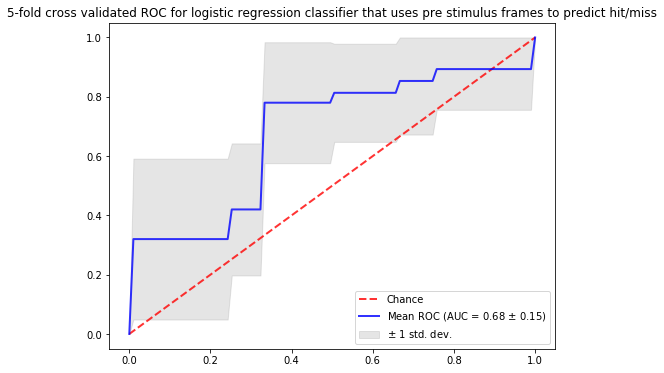

In [61]:
#plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="{}-fold cross validated ROC for logistic regression classifier that uses pre stimulus frames to predict hit/miss".format(folds))
ax.legend(loc="lower right")
plt.show()

# 4. Remove largest weights and repeat

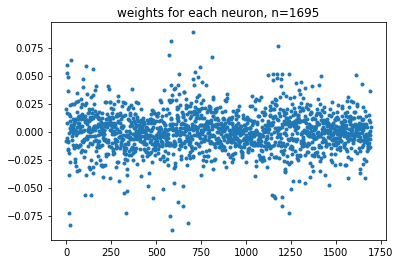

In [50]:
plt.plot(weights[0],'.')
plt.title('weights for each neuron, n={}'.format(len(weights[0])))
plt.show()

In [35]:
# find neurons with absolute weight value >x
large_weights = absolute(weights[0],0.04)
len(large_weights)

74

In [36]:
smol = np.copy(mean_dff_cell)
mean_dff_cell.shape

(1695, 43)

In [37]:
#remove neurons with large magnitude weights
smol = np.delete(smol,(large_weights), axis=0)
smol.shape

(1621, 43)

In [38]:
scaler.fit(smol)
smol_scaled = scaler.transform(smol)

In [39]:
X = smol_scaled.T
y = labels
folds = 5

cv = StratifiedKFold(n_splits=folds)
classifier = linear_model.LogisticRegression(max_iter=1e8, tol=1e-5,penalty='l2',solver='lbfgs')

tprs = []
aucs = []
weights_2 =[]
mean_fpr = np.linspace(0, 1, 100)

In [40]:
# split the data with StratifiedKFold and train n classifiers on training data
# predict probabilities for test data & compute ROCs

for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    probs = classifier.predict_proba(X[test])[:,1]
    fpr, tpr, thresholds = roc_curve(y[test], probs)
    interp_tpr = interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucscore = roc_auc_score(y[test], probs)
    aucs.append(aucscore)
    weights_2.append(classifier.coef_.T)

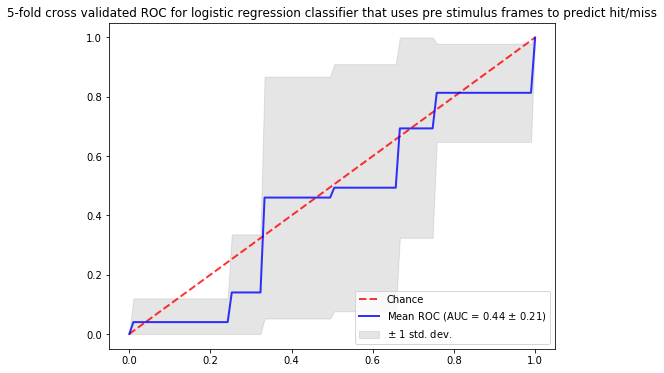

In [41]:
#plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="{}-fold cross validated ROC for logistic regression classifier that uses pre stimulus frames to predict hit/miss".format(folds))
ax.legend(loc="lower right")
plt.show()

In [42]:
clf = linear_model.LogisticRegression(max_iter=1e8, tol=1e-4,penalty='l2',solver='lbfgs')
scores = cross_val_score(clf, smol_scaled.T, labels, cv=10)
print("Model accuracy: %0.2f (95%% CI +/- %0.2f)" % (scores.mean(), scores.std() * 1.96))

Model accuracy: 0.64 (95% CI +/- 0.44)


# 5. Keep only largest weight magnitudes and repeat

In [229]:
# are negative weighted neurons as important as positive weighted, etc?
large_weights = absolute(weights[0],0.06) #take just weights where abs(w)>x
# large_weights = smaller(weights[0],-0.05) #take just weights where w<x
# large_weights = smaller(weights[0],-0.05) #take just weights where w>x
len(large_weights)

16

In [214]:
copy = np.copy(mean_dff_cell)
mean_dff_cell.shape

(1695, 43)

In [215]:
# keep only neurons with largest weight
biggy = copy[large_weights,:]
biggy.shape

(16, 43)

In [216]:
scaler.fit(biggy)
biggy_scaled = scaler.transform(biggy)

In [217]:
X = biggy_scaled.T
y = labels
folds = 5

cv = StratifiedKFold(n_splits=folds)
classifier = linear_model.LogisticRegression(max_iter=1e8, tol=1e-5,penalty='l2',solver='lbfgs')

tprs = []
aucs = []
weights_2 =[]
mean_fpr = np.linspace(0, 1, 100)

In [218]:
# split the data with StratifiedKFold and train n classifiers on training data
# predict probabilities for test data & compute ROCs

for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    probs = classifier.predict_proba(X[test])[:,1]
    fpr, tpr, thresholds = roc_curve(y[test], probs)
    interp_tpr = interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucscore = roc_auc_score(y[test], probs)
    aucs.append(aucscore)
    weights_2.append(classifier.coef_.T)

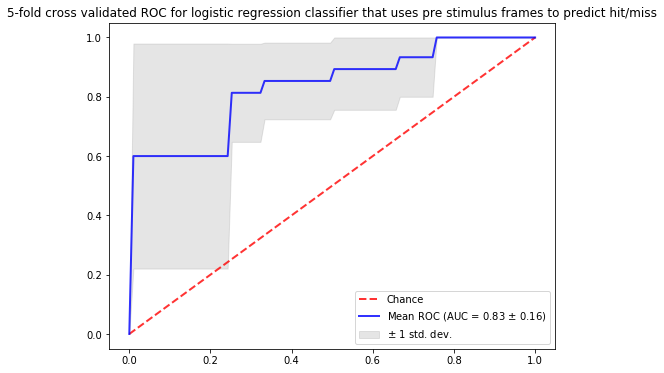

In [219]:
#plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="{}-fold cross validated ROC for logistic regression classifier that uses pre stimulus frames to predict hit/miss".format(folds))
ax.legend(loc="lower right")
plt.show()

In [220]:
clf = linear_model.LogisticRegression(max_iter=1e8, tol=1e-4,penalty='l2',solver='lbfgs')
scores = cross_val_score(clf, biggy_scaled.T, labels, cv=10)
print("Model accuracy: %0.2f (95%% CI +/- %0.2f)" % (scores.mean(), scores.std() * 1.96))

Model accuracy: 0.83 (95% CI +/- 0.26)


In [221]:
# look at the predictive neurons

In [222]:
large_weight_traces = data[large_weights,:,:]
large_weight_traces.shape

(16, 93, 10)

In [223]:
large_weight_traces[0,6,:]

array([-0.48282832, -0.29543018, -0.57638645, -0.49406487, -0.62952405,
       -0.42977887, -0.59766173, -0.31509617, -0.57353324, -0.40292448])

In [224]:
#get indices for hit trials
[i for i,l in enumerate(labels) if l==1]

[0,
 1,
 2,
 3,
 7,
 10,
 11,
 12,
 13,
 14,
 19,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 36]

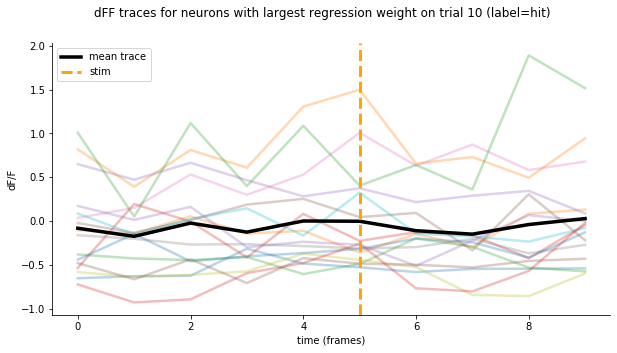

In [225]:
trial = 10
mean_trace = np.mean(large_weight_traces[:,trial,:],axis=0)
fig, ax = plt.subplots(1,1,figsize=(10,5))
plt.ylabel('dF/F')
plt.xlabel('time (frames)')
for i,unit in enumerate(large_weight_traces[:,trial,:]):
    line_offset = i*0
    ax.plot(unit-line_offset,linewidth=2.5,alpha=0.3)
ax.plot(mean_trace,linewidth=3.5,label='mean trace',color='black')
plt.axvline(5,linestyle='--',color='orange',label='stim',linewidth=3)
sns.despine()
plt.suptitle('dFF traces for neurons with largest regression weight on trial {} (label={})'.format(trial,go_labels[trial]))
plt.legend()
plt.show()

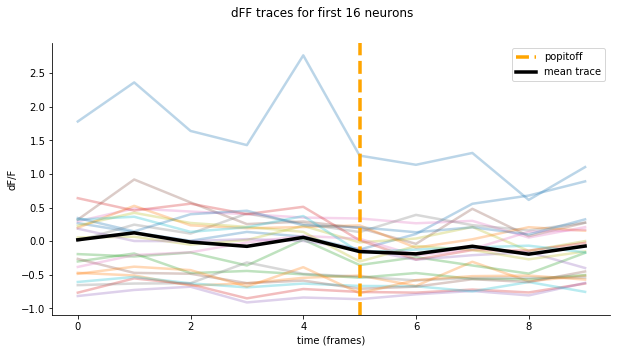

In [228]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_trace = np.mean(data[0:16,trial,:],axis=0)
plt.ylabel('dF/F')
plt.xlabel('time (frames)')
for i,unit in enumerate(data[0:22,trial,:]):
    line_offset = i*0
    ax.plot(unit-line_offset,linewidth=2.5,alpha=0.3)
plt.axvline(5,linestyle='--',color='orange',label='popitoff',linewidth=3.5)
ax.plot(mean_trace,linewidth=3.5,label='mean trace',color='black')
sns.despine()
plt.suptitle('dFF traces for first 16 neurons')
plt.legend()
plt.show()

In [227]:
large_weights

[17,
 23,
 25,
 331,
 573,
 575,
 585,
 587,
 619,
 652,
 678,
 704,
 812,
 1181,
 1202,
 1242]